In [25]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

import pickle

In [26]:
# Set this to where you want to store the resulting graph, census, and reward files
STORAGE_PATH = Path('./')

# Definint the problem graph

In [27]:
g = ig.Graph(directed=True)

## Graph Vertices
This means we require the definition of:
- Residential Centroids (RC)
- Public Transport Stations (PTS)
- Points of Interests (POI)

Here, `RC` vertices can be seen as origins and `POI` vertices as destinations.

In [28]:
V_RC = {f'RC{i+1}':i for i in range(2)}
V_RC_attr = {
    'name': [e for e in V_RC.keys()],
    'x': [0.5, 3.5],
    'y': [0.5, 3.5],
    'color': ['purple', 'red'],
    'type': 'rc_node'
}
g.add_vertices(V_RC.values(), V_RC_attr)

In [29]:
V_PTS = {f'PT{i+1}':e for i,e in enumerate(range(2,5))}
V_PTS_attr = {
    'name': [e for e in V_PTS.keys()],
    'x': [1,3,3.4],
    'y': [1,3,3.4],
    'color': 'blue',
    'type': 'pt_node'
}
g.add_vertices(V_PTS.values(), V_PTS_attr)

In [30]:
V_POI = {f'POI{i+1}':e for i,e in enumerate(range(5,6))}
V_POI_attr = {
    'name': [e for e in V_POI.keys()],
    'x': [2.75],
    'y': [2.75],
    'color': 'green',
    'type': 'poi_node'
}
g.add_vertices(V_POI.values(), V_POI_attr)

## Graph Edges
The original EPTNR definition allows for two general types of edges:
- Walking (WALK)
- Public Transport (PT)

Here, `PT` can be a connection between two `PTS` of any modality (tram, bus, train, etc.). The important aspect is the speed with which the modality cruises.

In [31]:
# Define speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour

In [32]:
def compute_dist_from_es(g: ig.Graph, es: list):
    """
    Function to compute the euclidean distances between all graph vertex pairs in a list
    Args:
        g: Graph object
        es: List of (int, int) tuples which indicate two connected vertices of graph g

    Returns:
        The euclidean distances between each vertex pair in the list
    """
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in es]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking
Walking edges connect `RC`s with `PTS`s, `RC`s with `POI`s, and `PTS`s with `POI`s to make sure that individuals can choose the truly shortest paths at all times (i.e. if the shortest path is walking instead of riding the metro, then that path is chosen).

In [33]:
E_WALK = list(it.product(V_RC.values(),V_PTS.values())) +\
         list(it.product(V_PTS.values(), V_POI.values())) +\
         list(it.product(V_RC.values(), V_POI.values()))
distances_walk = compute_dist_from_es(g, E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}

In [34]:
E_WALK_attr

{'distance': array([0.70710678, 3.53553391, 4.10121933, 3.53553391, 0.70710678,
        0.14142136, 2.47487373, 0.35355339, 0.91923882, 3.18198052,
        1.06066017]),
 'tt': array([ 8.48528137, 42.42640687, 49.21463197, 42.42640687,  8.48528137,
         1.69705627, 29.69848481,  4.24264069, 11.03086579, 38.18376618,
        12.72792206]),
 'weight': array([ 8.48528137, 42.42640687, 49.21463197, 42.42640687,  8.48528137,
         1.69705627, 29.69848481,  4.24264069, 11.03086579, 38.18376618,
        12.72792206]),
 'color': 'gray',
 'type': 'walk'}

In [35]:
g.add_edges(E_WALK, E_WALK_attr)

### PT
These are the public transport links between `PTS`s

In [36]:
E_BUS = [
    (V_PTS['PT1'],V_PTS['PT2']),  # Bus_line_1
    (V_PTS['PT2'],V_PTS['PT1']),  # Bus_line_1
    (V_PTS['PT2'],V_PTS['PT3']),  # Bus_line_2
    (V_PTS['PT3'],V_PTS['PT2']),  # Bus_line_2
]
distances_bus = compute_dist_from_es(g, E_BUS)
E_BUS_attr = {
    'name': list(it.repeat(f'Bus_line_1',2)) +
            list(it.repeat(f'Bus_line_2',2)),
    'distance': distances_bus,
    'tt': (distances_bus * 1/BUS_SPEED) * 60,
    'weight': (distances_bus * 1/BUS_SPEED) * 60,
    'color': 'pink',
    'type': 'bus',
}


In [37]:
g.add_edges(E_BUS, E_BUS_attr)

## Visual Inspection
Finally, we visually inspect the resulting graph. Gray edges indicate the walking connections while pink edges the bus connections defined above. We have the purple and red residential centroids and the green point of interest. The blue vertices are the two public transport stations.

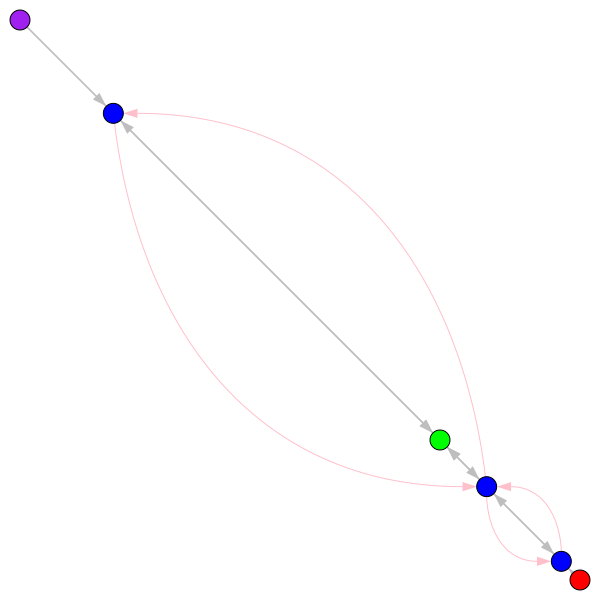

In [38]:
ig.plot(g)

## Saving the graph

In [39]:
# Set all edges to be active, i.e. usable
g.es['active'] = 1

In [40]:
g.write_picklez(STORAGE_PATH.joinpath('graph.picklez'))

# Census Data
Alongside with our graph we generate synthetic census data, describing the number of people living in each residential centroid and their group membership (in this case either red or purple).

In [41]:
data = {
    'neighborhood': V_RC_attr['name'],
    'n_inh': [1000,100],
    'n_purple': [1000,0],
    'n_red': [0,100],
    'res_centroids': gpd.points_from_xy(V_RC_attr['x'], V_RC_attr['y'])
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC1,1000,1000,0,POINT (0.50000 0.50000)
1,RC2,100,0,100,POINT (3.50000 3.50000)


In [42]:
gdf.to_file(STORAGE_PATH.joinpath('census.geojson'), driver='GeoJSON')

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Hard-coded rewards
If one would like to use hard-coded rewards rather than one of the rewards included in the EPTNR package, the following workflow can be used:
1. List all the possible removed states
2. Identify which edge represents which direction / bus line
3. Create a dictionary which assigns rewards to the sub-graph where the indicated edge is removed

In [43]:
edge_set = [e.index for e in g.es.select(type_ne='walk')]
possible_configurations = []

for i in range(len(edge_set) + 1):
    possible_configurations.extend(list(it.combinations(edge_set, i)))

print("List of all possible configurations of the graph:", "\n".join([str(e) for e in possible_configurations]))

List of all possible configurations of the graph: ()
(11,)
(12,)
(13,)
(14,)
(11, 12)
(11, 13)
(11, 14)
(12, 13)
(12, 14)
(13, 14)
(11, 12, 13)
(11, 12, 14)
(11, 13, 14)
(12, 13, 14)
(11, 12, 13, 14)


In [44]:
reward_dict = {
    (): 0,
    (11,): 10,
    (12,): 10,
    (13,): 10,
    (14,): 10,
    (11, 12): 10,
    (11, 13): 10,
    (11, 14): 10,
    (12, 13): 10,
    (12, 14): 10,
    (13, 14): 10,
    (11, 12, 13): 10,
    (11, 12, 14): 10,
    (11, 13, 14): 10,
    (12, 13, 14): 10,
    (11, 12, 13, 14) : 10,
}
pickle.dump(reward_dict, open(STORAGE_PATH.joinpath('hardcoded_rewards.pickle'), "wb"))

# Solution Plotting


## Egalitarian Reward

In [45]:
from eptnr.rewards import EgalitarianTheilReward, CustomReward

from eptnr.analysis.full_problem_exploration import full_problem_exploration
from eptnr.plotting.solution_plotting import plot_full_problem_exploration

In [46]:
# Feed the reward function with the necessary census data
census_data = gdf.copy()
census_data['geometry'] = census_data['res_centroids']
census_data = census_data[['neighborhood', 'n_inh', 'n_purple', 'n_red', 'geometry']]
r = EgalitarianTheilReward(census_data=census_data, com_threshold=15)

INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:Possible states: [[[]], [[11], [12], [13], [14]], [[11, 12], [11, 13], [11, 14], [12, 13], [12, 14], [13, 14]], [[11, 12, 13], [11, 12, 14], [11, 13, 14], [12, 13, 14]]]
  0%|          | 0/4 [00:00<?, ?it/s]INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [] obtained rewards [91.38995616965695]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [11] obtained rewards [0.00031415065169471167, -inf, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [12] obtained rewards [0.00031415065169471167, 91.38995616965695, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [13] obtained rewards [0.00031415065169471167, 91.38995616965695, 91.38995616965695, -inf]
INFO:/home/rico/Documents/the

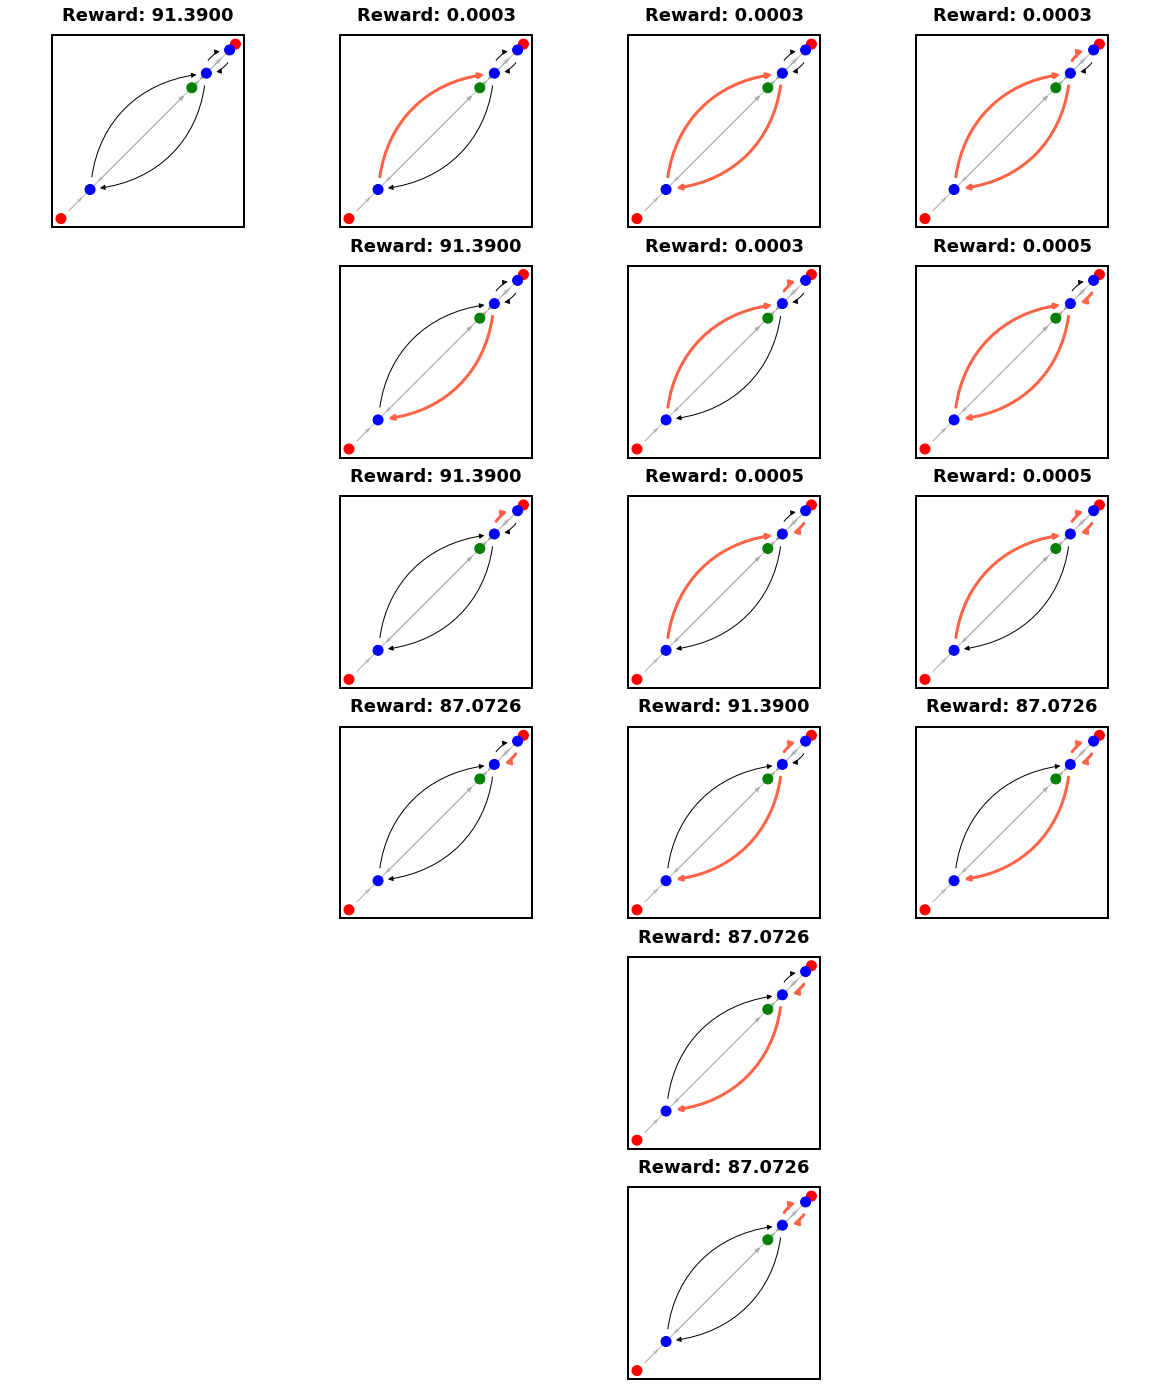

In [47]:
# Conduct an exhaustive configuration exploration
# Attention, bigger graphs could take a long time or be non-tractable
edge_types = list(np.unique(g.es['type']))
edge_types.remove('walk')

configurations, rewards = full_problem_exploration(g, r, edge_types)
fig, axs = plot_full_problem_exploration(base_graph=g, configurations=configurations, rewards=rewards)
plt.show()

## Hard-coded rewards

INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:Possible states: [[[]], [[11], [12], [13], [14]], [[11, 12], [11, 13], [11, 14], [12, 13], [12, 14], [13, 14]], [[11, 12, 13], [11, 12, 14], [11, 13, 14], [12, 13, 14]]]
  0%|          | 0/4 [00:00<?, ?it/s]INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [] obtained rewards [0]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [11] obtained rewards [10, -inf, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [12] obtained rewards [10, 10, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [13] obtained rewards [10, 10, 10, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [14] obtained rewards [10, 10, 10, 10]
INFO:/home/

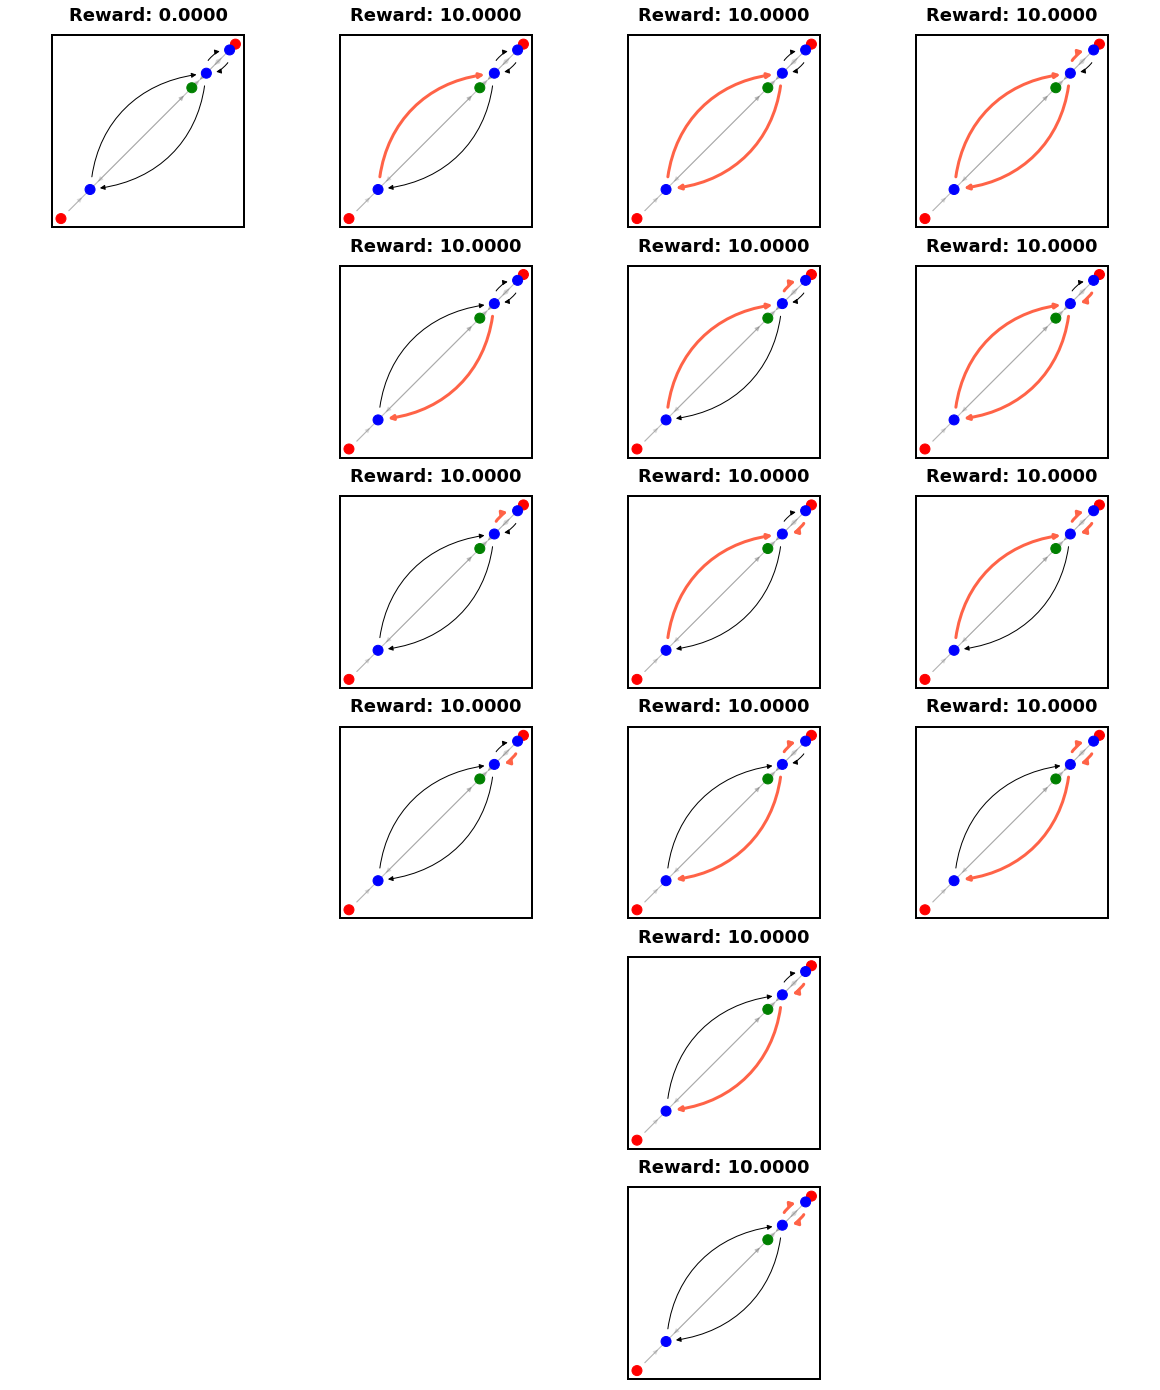

In [48]:
r = CustomReward(reward_dict=reward_dict, census_data=gdf, com_threshold=15)

edge_types = list(np.unique(g.es['type']))
edge_types.remove('walk')

configurations, rewards = full_problem_exploration(g, r, edge_types)
fig, axs = plot_full_problem_exploration(base_graph=g, configurations=configurations, rewards=rewards)
plt.show()